In [1]:
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os
import scipy.misc as s
import pandas as pd
import random

The labels of each face image is embedded in the file name, formated like [age] _ [gender] _ [race] _ [date&time].jpg

[age] is an integer from 0 to 116, indicating the age

[gender] is either 0 (male) or 1 (female)

[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

https://susanqq.github.io/UTKFace/

In [2]:
files = os.listdir("data/crop_part1/")

In [3]:
image_file = Image.open("data/crop_part1/100_1_0_20170110183726390.jpg.chip.jpg") # open colour image

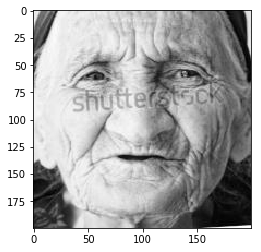

In [4]:
plt.imshow(np.dot(np.array(image_file)[:,:,:3], [0.2989, 0.5870, 0.1140]), cmap='gray')

In [7]:
random.shuffle(files) #randomizing the files to sample from it (this is just to save time)

In [96]:
male_faces = pd.DataFrame([])
female_faces = pd.DataFrame([])
m = 0
fe = 0
for f in files:
    if f.split('_')[1] == "0" and m<200: #male
        m += 1
        image_file = Image.open("data/crop_part1/" + f)
        image_file = image_file.resize((32,32), Image.ANTIALIAS)
        img = np.dot(np.array(image_file)[:,:,:3], [0.2989, 0.5870, 0.1140])/255 #convert to gray scale
        face = pd.Series(img.flatten(), name=f)
        male_faces = male_faces.append(face)
    if f.split('_')[1] == "1" and fe<200: #female
        fe += 1
        image_file = Image.open("data/crop_part1/" + f)
        image_file = image_file.resize((32,32), Image.ANTIALIAS)
        img = np.dot(np.array(image_file)[:,:,:3], [0.2989, 0.5870, 0.1140])/255 #convert to gray scale
        face = pd.Series(img.flatten(), name=f)
        female_faces = female_faces.append(face)

In [97]:
male_faces.shape, female_faces.shape

((200, 1024), (200, 1024))

In [98]:
all_faces = pd.concat([male_faces, female_faces], axis=0)
all_faces.shape

(400, 1024)

# PCA

In [99]:
from sklearn.decomposition import PCA

In [10]:
faces_pca = PCA(n_components=20)
faces_pca.fit(all_faces)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [12]:
components = faces_pca.transform(all_faces)
projected = faces_pca.inverse_transform(components) #Reconstruction of the original image

In [13]:
projected.shape

(400, 40000)

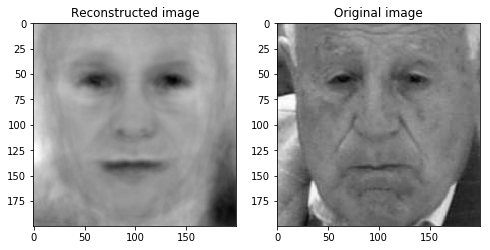

Reconstruction error is :  13.71505640042158


In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
axes[0].imshow(projected[2].reshape((200,200)), cmap='gray')
axes[0].set_title("Reconstructed image")
axes[1].imshow(np.array(all_faces)[2].reshape((200,200)), cmap='gray')
axes[1].set_title("Original image")
plt.show()
print("Reconstruction error is : ", np.sqrt(np.sum(np.square(np.array(all_faces)[2].reshape((200,200)) - projected[2].reshape((200,200))))))

In [15]:
#Computing reconstruction error 
def RE_error(df1, df2):
    arr1 = np.array(df1)
    arr2 = np.array(df2)
    res = []
    for sample in range(arr2.shape[0]):
        res.append(np.sqrt(np.sum(np.square(arr1[sample] - arr2[sample]))))
    return np.mean(res)

### Bias between males and females in PCA 

In [17]:
re_male = []
re_female = []
dim = [d for d in range(2,30)]
for d in dim:
    faces_pca = PCA(n_components=d)
    faces_pca.fit(all_faces)
    components = faces_pca.transform(all_faces)
    projected = faces_pca.inverse_transform(components)
    #computing RE for men with dimensionnality reduction d
    re_male.append(RE_error(all_faces[:200], projected[:200]))
    #computing RE for women with dimensionnality reduction d
    re_female.append(RE_error(all_faces[200:], projected[200:]))

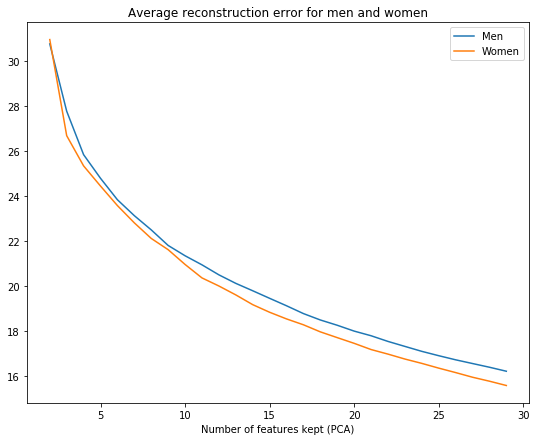

In [18]:
plt.figure(figsize=(9, 7))
plt.plot(dim, re_male, label="Men")
plt.plot(dim, re_female, label="Women")
plt.legend()
plt.title("Average reconstruction error for men and women")
plt.xlabel("Number of features kept (PCA)")
plt.show()

# Fair PCA - Implementation

**First implement the Oracle function**

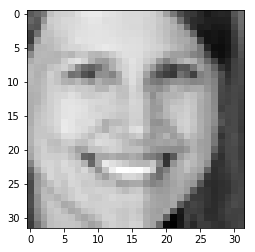

In [101]:
toy = np.array(all_faces)[314].reshape((32,32))
plt.imshow(toy, cmap='gray')

In [102]:
u,s,v = np.linalg.svd(toy)
u.shape, s.shape, v.shape

((32, 32), (32,), (32, 32))

In [103]:
d = 20

In [104]:
frob_innerproduct(toy,toy)

275.330878262489

In [105]:
def frob_innerproduct(a, b):
    return np.trace(a.T @ b)

In [106]:
def oracle(p, alpha, beta, A, B):
    """ Oracle fo Fair PCA - Algorithm 2
        -----------
        Parameters :
        p : tuple of size 2 such that each component are positive and sum to 1.
        alpha : float
        beta : float
        A : array of shape (m1, n)
        B : array of shape (m2, n)
        -----------
        Returns : 
        P, z1, z2 such that : 
            
            P, z1, z2 = argmin p1*z1 + p2*z2
            s.t.
                z1 = alpha - 1/m1 <A'A, P>
                z2 = beta - 1/m1 <B'B, P>
                P is a matrix of size nxn such that 0 <= P <= P and Tr(P) <= d.
    """
    pca = PCA(n_components=d)
    p1, p2, m1, m2 = p[0], p[1], A.shape[0], B.shape[0]
    mat = p1/m1 * A.T @ A + p2/m2 * B.T @ B
    pca.fit(mat)
    V = pca.transform(mat)
    P = V@V.T
    z1 = alpha - (1/m1) * frob_innerproduct(A.T @ A, P)
    z2 = beta - (1/m2) * frob_innerproduct(B.T @ B, P)
    return P, z1, z2

In [107]:
p = [0.5, 0.5]
alpha = 2
beta = 2
A = np.array(male_faces)
B = np.array(female_faces)
A.shape, B.shape

((200, 1024), (200, 1024))

In [108]:
P, z1, z2 = oracle(p, alpha, beta, A, B)

In [109]:
z1, z2

(-11315.380511850142, -20189.92567757753)

In [110]:
P.shape

(1024, 1024)

In [111]:
def MW_PCA(alpha, beta, A, B, eta, T):
    """ Multiplicative weight update for faire PCA - Algorithm 3
        -----------
        Parameters :
        alpha : float
        beta : float
        A : array of shape (m1, n)
        B : array of shape (m2, n)
        eta : float, must be stricly positive
        T : int, must be positive (According to the reference paper, no need for T to be very large : a fews tens)
        -----------
        Returns : 
        P, z such that : 
            
            P, z = argmin z
            s.t.
                z1 >= alpha - 1/m1 <A'A, P>
                z2 >= beta - 1/m2 <B'B, P>
                P is a matrix of size nxn such that 0 <= P <= P and Tr(P) <= d.
    """
    p = [0.5, 0.5] #initialize values for p for the oracle function
    Ps = []
    m1, m2 = A.shape[0], B.shape[0]
    #Looping T times
    for t in range(1, T+1):
        Pt, m1t, m2t = oracle(p, alpha, beta, A, B)
        Ps.append(Pt)
        p_hat1, p_hat2 = p[0] * np.exp(eta*m1), p[1] * np.exp(eta*m2)
        s = p_hat1 + p_hat2
        p = [p_hat1/s, p_hat2/s]
    #return values found
    P = np.mean(Ps, axis=0)
    z = max(alpha - (1/m1) * frob_innerproduct(A.T @ A, P), beta - (1/m2) * frob_innerproduct(B.T @ B, P))
    return P, z

In [112]:
P, z = MW_PCA(alpha, beta, A, B, eta, T)

In [113]:
P.shape

(1024, 1024)

In [114]:
P_U, P_eig, P_V = np.linalg.svd(P)

In [116]:
J = np.outer(P_U[:, 0], P_V[:, 0]) * P_eig[0]
for i in range(1, 1024):
    J += np.outer(P_U[:, i], P_V[:, i]) * P_eig[i]

**All steps of algorithm 1 (Fair PCA) are done except step 4 : solving the following linear program** 

We do it now : 

Program :


$\min_{\lambda \in \mathbb{R}^{n}, z \in \mathbb{R}} \; z $

s.t. 

$0 \leq \lambda_i \leq 1$ 


$\sum_{i} \lambda_i \leq d$

$-z - \sum_{i} \lambda_i \cdot <B^{T}B, u_j, u_j^{T}> \; \leq  - \frac{|| \hat{B} ||_F^2}{m2}$


$-z - \sum_{i} \lambda_i \cdot <A^{T}A, u_j, u_j^{T}> \; \leq  - \frac{|| \hat{A} ||_F^2}{m1}$


To solve this linear program we first write it in its canonical form : 



**mettre les formules** 



In [125]:
from cvxopt import matrix, solvers

In [128]:
def rank_approx(M, d):
    """ Low rank approximation of matrices using SVD decomposition
        -----------
        Parameters :
        M : array 
        d : lower dimension wanted
        -----------
        Returns : 
        L, optimal rank d approximation of M.
    """
    M_U, M_eig, M_V = np.linalg.svd(M)
    L = np.outer(M_U[:, 0], M_V[:, 0]) * M_eig[0]
    for j in range(1,d):
        L += np.outer(M_U[:, j], M_V[:, j]) * M_eig[j]
    return L

In [192]:
def fair_PCA(A, B, d):
    """ Fair PCA - Algorithm 1
        -----------
        Parameters :
        A : array of shape (m1, n)
        B : array of shape (m2, n)
        d : lower dimension wanted
        -----------
        Returns : 
        U of shape (m, n) st m = m1 + m2 and rank(U) <= d+1
    """
    #step 1 
    A_hat = rank_approx(A, d)
    B_hat = rank_approx(B, d)
    print("Step 1 done")
    print("-----------")
    #step 2 
    alpha, beta, eta, T = 2, 2, 2, 2
    P, z = MW_PCA(alpha, beta, A, B, eta, T)
    print("Step 2 done")
    print("-----------")
    #step 3 
    P_U, P_eig, P_V = np.linalg.svd(P)
    print("Step 3 done")
    print("-----------")
    #step 4 
    #Here we will solve a LP, we first constuct matrices in order to write the LP problem 
    #in a canonical form as explained earlier (so we can use a library to solve it).
    n = A.shape[1]
    #construct a matrix of constraint : 
    A_lp_const = np.pad(np.eye(n), ((1,2), (0,1)), mode='constant', constant_values=((1,0), (0,0)))
    A_lp_const[n+1, n] = -1
    A_lp_const[n+2, n] = -1
    ata = A.T @ A
    btb = B.T @ B
    for j in range(n):
        fAj = frob_innerproduct(ata, np.outer(P_U[:, j], P_V[:, j]))
        fBj = frob_innerproduct(btb, np.outer(P_U[:, j], P_V[:, j]))
        A_lp_const[n+1, j] = fAj
        A_lp_const[n+2, j] = fBj
    A_lp_const = np.concatenate((np.pad(-np.eye(n), ((0,0), (0,1)), mode='constant', constant_values=((0,0), (0,0))), A_lp_const))
    #now construct vector of values (i.e. b ) and coefficients (i.e. c)
    m1, m2 = A.shape[1], B.shape[1]
    b = np.ones(n+2)
    b[0] = d 
    b[-1] = -frob_innerproduct(B_hat, B_hat)/m2
    b[-2] = -frob_innerproduct(A_hat, A_hat)/m1
    b = np.concatenate((b, np.zeros(n)))
    c = np.zeros(n+1)
    c[-1] = 1
    print("Starting LP solve...")
    #A,b,c must in the "matrix" library format
    coefs = solvers.lp(matrix(list(c)),matrix(Alp),matrix(list(blp)),show_progress=False)
    z_opt = np.array(coefs['x'])[-1]
    lambda_bar = np.array(coefs['x'])[:-1]
    print("Step 4 done")
    print("-----------")
    #Step 5 : construct lambda* and P*
    lambda_bar = 1 - np.sqrt(1-lambda_bar)
    P_star = np.outer(P_U[:, 0], P_V[:, 0]) * lambda_bar[0]
    for j in range(1, len(lambda_bar)):
        P_star += np.outer(P_U[:, j], P_V[:, j]) * lambda_bar[j]
    print("Step 5 done")
    print("-----------")
    #Finally construct U (pca matrix)
    U = np.concatenate((A, B)) @ P_star
    return U

In [193]:
U = fair_PCA(A, B, 20)

Step 1 done
-----------
Step 2 done
-----------
Step 3 done
-----------
Starting LP solve...
     pcost       dcost       gap    pres   dres   k/t
 0: -4.8074e+03 -1.8265e+05  2e+07  2e+01  7e+05  1e+00
 1: -1.0629e+05 -4.2331e+05  8e+07  4e+01  1e+06  1e+04
 2:  4.7421e+06 -2.0007e+07  7e+11  3e+03  1e+08  5e+06
 3: -6.3082e+05 -3.1306e+05  3e+08  4e+01  1e+06  7e+05
 4: -1.8805e+07 -5.6101e+05  2e+10  7e+01  2e+06  2e+07
 5: -1.8524e+09 -5.6569e+05  2e+12  7e+01  2e+06  2e+09
Certificate of dual infeasibility found.
Step 4 done
-----------
Step 5 done
-----------


In [195]:
U.shape

(400, 1024)

In [196]:
np.linalg.matrix_rank(U) #mdr 

400